In [82]:
import argparse
import os

# temporary solution for CUDA OOM: disable cuda 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=""
import time
import torch
print(torch.cuda.is_available())

import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import torch
import imageio
import matplotlib.pyplot as plt
import sys
import matplotlib.cm as cm
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from model_selection import select_model, model_type, pre_trained_model_types, fine_tuned_model_types
from datasets.util import pad_to_same_shape
torch.set_grad_enabled(False)
from utils_flow.pixel_wise_mapping import remap_using_flow_fields
from utils_flow.visualization_utils import overlay_semantic_mask, make_sparse_matching_plot
from utils_flow.util_optical_flow import flow_to_image  
from models.inference_utils import estimate_mask
from utils_flow.flow_and_mapping_operations import convert_flow_to_mapping
from validation.utils import matches_from_flow
from validation.test_parser import define_model_parser, define_pdcnet_parser
from admin.stats import DotDict 
# %env CUDA_VISIBLE_DEVICES=""

%matplotlib inline

False


## Arguments


In [83]:
# put all arguments here 
query_cam_idx = 0
ref_cam_idx = 1
occlusion = False
reference_image_path = f'/home/junting/repo/ndf_robot/src/ndf_robot/data/images/bottle/cam_{query_cam_idx}/e9371d3abbb3bb7265bca0cae1ecfff5_rgb.png'
if occlusion:
    query_image_path = f'/home/junting/repo/ndf_robot/src/ndf_robot/data/demo_images/bottle/grasp_side_place_shelf_start_upright_all_methods_multi_instance/grasp_demo_2bbd2b37776088354e23e9314af9ae57/rgb_cam_{ref_cam_idx}.png' 
else:
    query_image_path = f'/home/junting/repo/ndf_robot/src/ndf_robot/data/demo_images_no_occlusion/bottle/grasp_side_place_shelf_start_upright_all_methods_multi_instance/grasp_demo_2bbd2b37776088354e23e9314af9ae57/rgb_cam_{ref_cam_idx}.png' 
demo_file_path = '/home/junting/repo/ndf_robot/src/ndf_robot/data/demos/bottle/grasp_side_place_shelf_start_upright_all_methods_multi_instance/grasp_demo_2bbd2b37776088354e23e9314af9ae57.npz'
model = 'PWarpCSFNet_WS'
pre_trained_model = 'ndf_from_WS_pfpascal'
flipping_condition = False 
global_optim_iter = 3
local_optim_iter = 7 
path_to_pre_trained_models = '../pre_trained_models/' 
    
if model not in model_type:
    raise ValueError('The model that you chose is not valid: {}'.format(model))
if pre_trained_model not in pre_trained_model_types + fine_tuned_model_types:
    raise ValueError('The pre-trained model type that you chose is not valid: {}'.format(pre_trained_model))


# Visualize the images to match

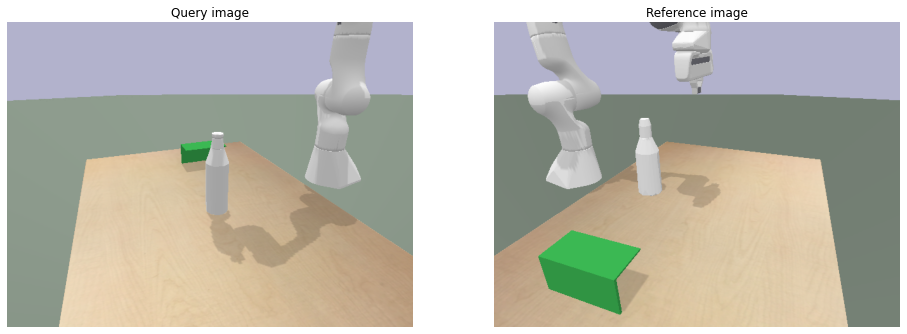

In [84]:
query_image = imageio.imread(query_image_path, pilmode='RGB')
reference_image = imageio.imread(reference_image_path, pilmode='RGB')
query_image_shape = query_image.shape
ref_image_shape = reference_image.shape
fig = plt.figure(figsize=(16,8))
fig.add_subplot(1,2,1)
plt.imshow(query_image)
plt.title('Query image')
plt.axis('off')
fig.add_subplot(1,2,2)
plt.imshow(reference_image)
plt.title('Reference image')
plt.axis('off')
plt.show()

# Choose the model, and run it to estimate the flow field relating the image pair

In [85]:
# print('Possible model types are:')
# print(model_type)
# print('\nPossible pre-trained model types are:')
# print(pre_trained_model_types)
# print('\nPossible fine-tuned model types are:')
# print(fine_tuned_model_types)

In [86]:
# add arguments parser 
def boolean_string(s):
    if s not in {'False', 'True'}:
        raise ValueError('Not a valid boolean string')
    return s == 'True'


parser = argparse.ArgumentParser(description='Test models on a pair of images')

parser.add_argument('--model', type=str, default=model_type,
                    help='Model to use')
parser.add_argument('--pre_trained_model', type=str, default=pre_trained_model)

parser.add_argument('--flipping_condition', default=False, type=boolean_string,
                    help='Apply flipping condition for semantic data and GLU-Net-based networks? ')
parser.add_argument('--optim_iter', type=int, default=global_optim_iter,
                    help='number of optim iter for global GOCor, when applicable')
parser.add_argument('--local_optim_iter', dest='local_optim_iter', type=int, default=local_optim_iter,
                    help='number of optim iter for local GOCor, when applicable')
parser.add_argument('--path_to_pre_trained_models', type=str, default=path_to_pre_trained_models,
                    help='path to the folder containing the pre trained model weights, or '
                            'path to the model checkpoint.')

parser.add_argument('--path_query_image', type=str,
                    help='Path to the source image.', default=query_image_path)
parser.add_argument('--path_reference_image', type=str,
                    help='Path to the target image.', default=reference_image_path)
parser.add_argument('--save_dir', type=str, default="../evaluation",
                    help='Directory where to save output figure.')
parser.add_argument('--save_ind_images', dest='save_ind_images',  default=False, type=boolean_string,
                    help='Save individual images? ')
subparsers = parser.add_subparsers(dest='network_type')
define_pdcnet_parser(subparsers)
args = parser.parse_args("")

In [87]:
# define network and load network weights
network, estimate_uncertainty = select_model(
    model, pre_trained_model, args, global_optim_iter, local_optim_iter,
    path_to_pre_trained_models=path_to_pre_trained_models)
estimate_uncertainty = True  
# here, we overwrite it, to also estimate uncertainty according to forward-backward for networks that do not predict a confidence measure

Model: PWarpCSFNet_WS
Pre-trained-model: ndf_from_WS_pfpascal


In [88]:
# convert the images to correct format to be processed by the network: torch Tensors, format B, C, H, W. 
# pad both images to the same size, to be processed by network
query_image_, reference_image_ = pad_to_same_shape(query_image, reference_image)
# convert numpy to torch tensor and put it in right format
query_image_ = torch.from_numpy(query_image_).permute(2, 0, 1).unsqueeze(0)
reference_image_ = torch.from_numpy(reference_image_).permute(2, 0, 1).unsqueeze(0)

In [89]:
if estimate_uncertainty:
    estimated_flow, uncertainty_components = network.estimate_flow_and_confidence_map(query_image_, reference_image_)
else:
    if args.flipping_condition and 'GLUNet' in args.model:
        estimated_flow = network.estimate_flow_with_flipping_condition(query_image_, reference_image_,
                                                                       mode='channel_first')
    else:
        estimated_flow = network.estimate_flow(query_image_, reference_image_, mode='channel_first')
# removes the padding
estimated_flow = estimated_flow[:, :, :ref_image_shape[0], :ref_image_shape[1]]

# convert to numpy and reformat
estimated_flow_numpy = estimated_flow.squeeze().permute(1, 2, 0).cpu().numpy()

# warp the query image according to the estimated flow
warped_query_image = remap_using_flow_fields(query_image, estimated_flow_numpy[:, :, 0],
                                             estimated_flow_numpy[:, :, 1]).astype(np.uint8)

# Visualization of the warped query and estimated flow field 

/tmp/ipykernel_87866/189285036.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


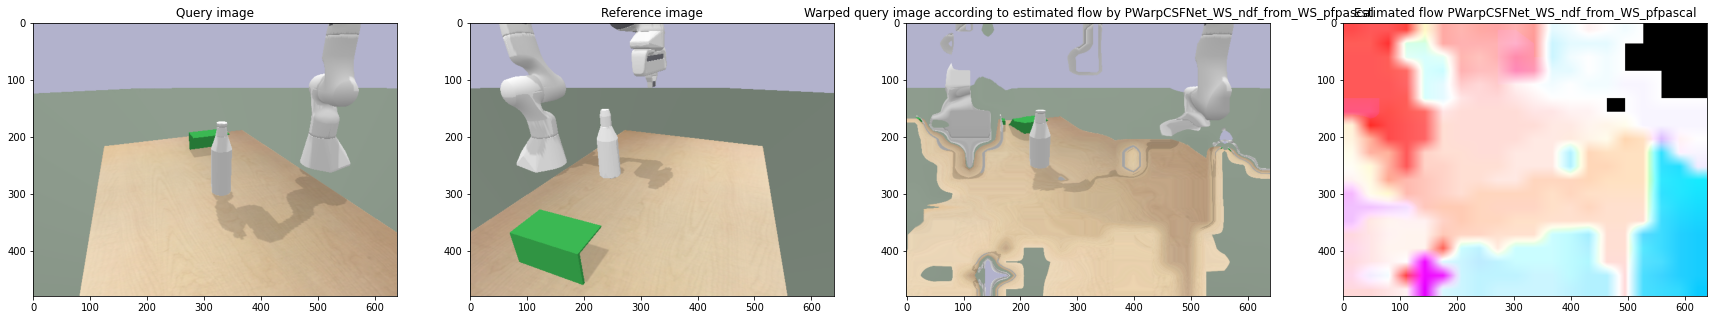

In [90]:
# visualization of warped query image 
fig, axis = plt.subplots(1, 4, figsize=(30, 30))
axis[2].imshow(warped_query_image)
axis[2].set_title(
    'Warped query image according to estimated flow by {}_{}'.format(model, pre_trained_model))
axis[0].imshow(query_image)
axis[0].set_title('Query image')
axis[1].imshow(reference_image)
axis[1].set_title('Reference image')

axis[3].imshow(flow_to_image(estimated_flow_numpy))
axis[3].set_title('Estimated flow {}_{}'.format(model, pre_trained_model))
fig.show()
plt.show()

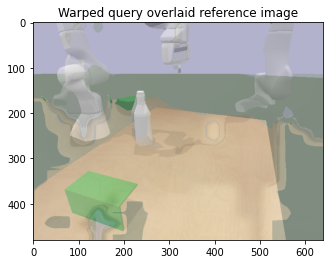

In [91]:
alpha = 0.5
img_warped_overlay_on_target_masked = warped_query_image * alpha + reference_image * alpha
plt.imshow(img_warped_overlay_on_target_masked.astype(np.uint8))
plt.title('Warped query overlaid reference image')
plt.show()

# Plot matches of contact points / query points


In [92]:
# load contact points / pixels from demo files 
demo_data = np.load(demo_file_path, allow_pickle=True)
print(list(demo_data.keys()))

int_mats = demo_data['intrinsic_matrices']
ext_mats = demo_data['extrinsic_matrices']
int_mat = int_mats[ref_cam_idx]
ext_mat = ext_mats[ref_cam_idx]
contact_pts_pybullet = demo_data['contact_points'] # in pybullet format https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit#heading=h.cb0co8y2vuvc
contact_pts = [pts_pybullet[5] for pts_pybullet in contact_pts_pybullet]
print(f"contact points: {contact_pts}")

['shapenet_id', 'ee_pose_world', 'robot_joints', 'obj_pose_world', 'obj_pose_camera', 'object_pointcloud', 'rgb', 'depth_full', 'depth', 'seg', 'camera_poses', 'obj_model_file', 'obj_model_file_dec', 'gripper_pts', 'gripper_pts_gaussian', 'gripper_pts_uniform', 'gripper_contact_pose', 'table_urdf', 'pcd_raw', 'cam_intrinsics', 'contact_points', 'instrinsic_matrices', 'extrinsic_matrices', 'intrinsic_matrices']
contact points: [(0.46693939719317723, -0.0016205928137917186, 1.2304113568677422), (0.45721196484445703, 0.010104648832274327, 1.2131427871725804)]


In [93]:
# project contact points onto image
def project_points_to_pixels(pts, ext_mat, int_mat):
    pts = np.array(pts)
    pts_homo = np.concatenate([pts, np.ones((pts.shape[0], 1))], axis=1) # (N,4)
    proj_mat = int_mat @ ext_mat[:3, :]
    pix_homo = proj_mat @ pts_homo.T # (3, N)
    pixels = (pix_homo[:2,:] / pix_homo[2,:]).T # (N, 2)

    return pixels
# (x,y) format, need to convert to (row, col)
contact_pixels = project_points_to_pixels(contact_pts, ext_mat, int_mat)


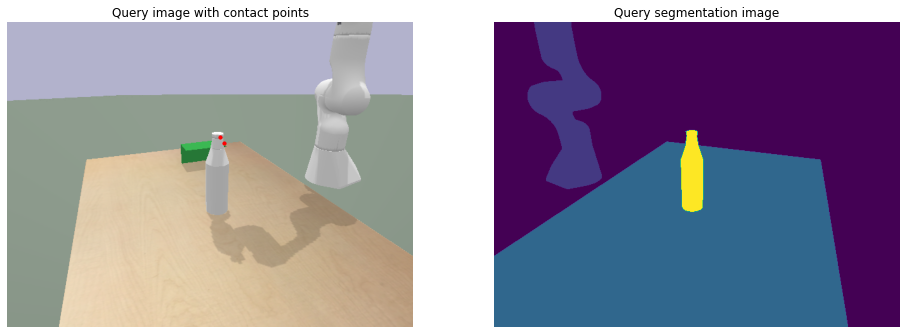

In [94]:
# plot segmentation image
query_seg_path = os.path.join(os.path.dirname(query_image_path), f'seg_cam_{query_cam_idx}.png')
# reference_image = imageio.imread(reference_image_path, pilmode='RGB')
query_seg_image = imageio.imread(query_seg_path)
# plt.hist(ref_seg_image.flatten(), bins='auto', log=True)  # arguments are passed to np.histogram
# plt.title("Histogram of segmentation image")
# values, counts = np.unique(ref_seg_image.flatten(), return_counts=True)
# print(dict(zip(values, counts)))
# output: {0: 86596, 1: 39699, 2: 119453, 6: 2528, 255: 58924} 
# 0 for ground and 255 for null, 1 & 2 for table, rack and robotic arm 
query_seg_image[query_seg_image==255] = 0
query_image_shape = query_image.shape
ref_image_shape = reference_image.shape
fig = plt.figure(figsize=(16,8))
fig.add_subplot(1,2,1)
plt.scatter(x=contact_pixels[:,0], y=contact_pixels[:,1], s=10, c='red', marker='o')
plt.imshow(query_image)
plt.title('Query image with contact points')
plt.axis('off')
fig.add_subplot(1,2,2)
plt.imshow(query_seg_image)
plt.title('Query segmentation image')
plt.axis('off')
plt.show()

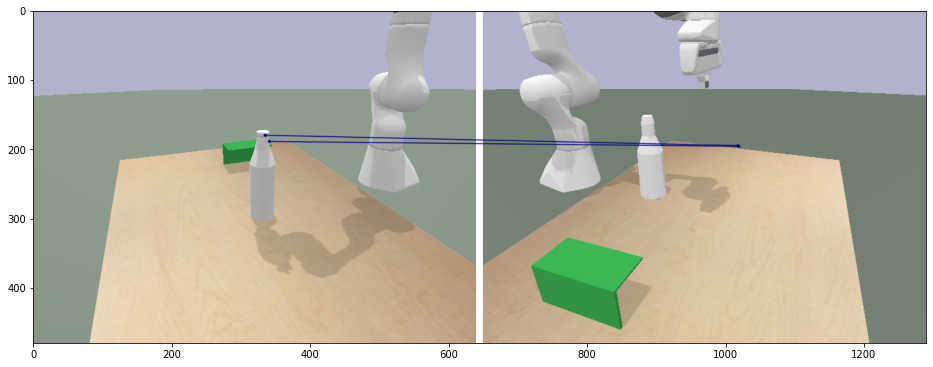

In [97]:
# plot the confident matches, here at original resolution, could have computed at 1/4th resolution
# this can also direclty be computed with 
#network.get_matches_and_confidence(source_image, target_image)

# get the mask according to uncertainty estimation
# mask_type = 'proba_interval_1_above_10' # 'cyclic_consistency_error_below_2' 
# mask_padded = estimate_mask(mask_type, uncertainty_components) 
# if 'warping_mask' in list(uncertainty_components.keys()):
#     # get mask from internal multi stage alignment, if it took place
#     mask_padded = uncertainty_components['warping_mask'] * mask_padded

# # remove the padding
# mask = mask_padded[:, :ref_image_shape[0], :ref_image_shape[1]]

# # remove point that lead to outside the query image
# mapping_estimated = convert_flow_to_mapping(estimated_flow)
# mask = mask & mapping_estimated[:, 0].ge(0) & mapping_estimated[:, 1].ge(0) & \
# mapping_estimated[:, 0].le(query_image_shape[1] - 1) & mapping_estimated[:, 1].le(query_image_shape[0] - 1)

# mkpts_query, mkpts_ref = matches_from_flow(estimated_flow, mask)

# confidence_values = confidence_map.squeeze()[mask.squeeze()].cpu().numpy()
# sort_index = np.argsort(np.array(confidence_values)).tolist()[::-1]  # from highest to smallest
# confidence_values = np.array(confidence_values)[sort_index]
# mkpts_query = np.array(mkpts_query)[sort_index]
# mkpts_ref = np.array(mkpts_ref)[sort_index]

# if len(mkpts_query) < 5:
#     mkpts_query = np.empty([0, 2], dtype=np.float32)
#     mkpts_ref = np.empty([0, 2], dtype=np.float32)
#     confidence_values = np.empty([0], dtype=np.float32)
    
# plot top 300
# k_top = 10000
# mkpts_q = mkpts_query[:k_top]
# mkpts_r = mkpts_ref[:k_top]
# confidence_values = confidence_values[:k_top]
shift = [estimated_flow_numpy[p[1], p[0]] for p in contact_pixels.astype(np.int8)]
mkpts_q = contact_pixels
mkpts_r = contact_pixels + np.array(shift)
confidence_values = np.ones(mkpts_q.shape[0])
color = cm.jet(confidence_values)
out = make_sparse_matching_plot(query_image, reference_image, mkpts_q, mkpts_r, color, margin=10)

plt.figure(figsize = (16,8))
plt.imshow(out)
plt.show()

In [96]:
shift

[array([33.5     , 14.773409], dtype=float32),
 array([27.989576 ,  6.4999695], dtype=float32)]